In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('final_merged_dataset.csv')

# Check data types
print("Data type check:")
print(df.dtypes)

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nNon-numeric columns found: {non_numeric_cols}")

    # Attempt to convert non-numeric columns to numeric
    for col in non_numeric_cols:
        try:
            # Try converting to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Successfully converted column '{col}' to numeric")
        except Exception as e:
            print(f"Failed to convert column '{col}' to numeric: {str(e)}")

# Split features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
columns = df.iloc[:, :-1].columns.values

# Generate descriptive statistics
descriptive_statistic = df.describe().T
print(descriptive_statistic)

# Save descriptive statistics to Excel
descriptive_statistic.to_excel("descriptive_statistic.xlsx")


Data type check:
fyear                            int64
gvkey                            int64
p_aaer                         float64
misstate                         int64
act                            float64
                                ...   
lag1_annual_adjusted_return     object
annual_volatility              float64
chairman_ceo_duality           float64
genderratio                    float64
numberdirectors                float64
Length: 66, dtype: object

Non-numeric columns found: ['annual_adjusted_return', 'lag1_annual_adjusted_return']
Successfully converted column 'annual_adjusted_return' to numeric
Successfully converted column 'lag1_annual_adjusted_return' to numeric
                               count          mean           std       min  \
fyear                        49267.0   2006.694461      4.183297  2000.000   
gvkey                        49267.0  54124.197739  58537.338497  1004.000   
p_aaer                         586.0   3026.901024    552.857389  1542.

In [3]:
target_column = 'misstate'

# Ensure that the 'fyear' column exists
if 'fyear' not in df.columns:
    raise ValueError("The dataset must contain an 'fyear' column for time-based splitting")

# Print basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Unique values of the target variable '{target_column}': {df[target_column].unique()}")
print(f"Value counts of the target variable '{target_column}':\n{df[target_column].value_counts()}")

# Check and handle potential missing values
print(f"Total number of missing values in the dataset: {df.isna().sum().sum()}")
if df.isna().sum().sum() > 0:
    print("Number of missing values per column:")
    print(df.isna().sum())

    # Drop rows with missing values in the target variable
    df = df.dropna(subset=[target_column])
    print(f"Dataset shape after dropping missing values in the target column: {df.shape}")


Dataset shape: (49267, 66)
Unique values of the target variable 'misstate': [0 1]
Value counts of the target variable 'misstate':
0    48681
1      586
Name: misstate, dtype: int64
Total number of missing values in the dataset: 197237
Number of missing values per column:
fyear                              0
gvkey                              0
p_aaer                         48681
misstate                           0
act                                0
                               ...  
lag1_annual_adjusted_return    26670
annual_volatility               2633
chairman_ceo_duality           11788
genderratio                    11788
numberdirectors                11788
Length: 66, dtype: int64
Dataset shape after dropping missing values in the target column: (49267, 66)


In [4]:
# 定义各个类别的变量
financial_raw_vars = [
    'act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 
    'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 
    'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk', 'txp', 'txt', 'xint', 'prcc_f'
]

financial_ratio_vars = [
    'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 
    'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf'
]

market_vars = [
    'lag1_annual_spread', 'annual_adjusted_return', 
    'lag1_annual_adjusted_return', 'annual_volatility'
]

audit_vars = [
    'ln_audit_fees', 'ln_non_audit_fees', 'ln_total_fees', 
    'audit_ratio', 'non_audit_ratio', 'audit_fees_pctrank', 
    'non_audit_fees_pctrank', 'total_fees_pctrank'
]

governance_vars = [
    'chairman_ceo_duality', 'genderratio', 'numberdirectors'
]

# 其他特征 = 市场变量 + 审计变量 + 治理变量
other_features = market_vars + audit_vars + governance_vars

# 定义三个特征组合
feature_sets = {
    # 第一类: 财务原始变量 + 其他特征
    'Financial_Raw_And_Other_Features': financial_raw_vars + other_features,
    
    # 第二类: 财务比率 + 其他特征
    'Financial_Ratios_And_Other_Features': financial_ratio_vars + other_features,
    
    # 第三类: 财务原始变量 + 财务比率 + 其他特征
    'All_Financial_And_Other_Features': financial_raw_vars + financial_ratio_vars + other_features
}

# 打印每个组合的特征数量
for set_name, features in feature_sets.items():
    print(f"{set_name}: {len(features)}个特征")


Financial_Raw_And_Other_Features: 43个特征
Financial_Ratios_And_Other_Features: 29个特征
All_Financial_And_Other_Features: 57个特征


In [5]:
# Define the year ranges for training, validation, and testing
train_start_year = 2000
train_end_year = 2009
val_start_year = 2010
val_end_year = 2011
test_start_year = 2012
test_end_year = 2014

# Split the dataset into training, validation, and testing sets
train_df = df[(df['fyear'] >= train_start_year) & (df['fyear'] <= train_end_year)].copy()
val_df = df[(df['fyear'] >= val_start_year) & (df['fyear'] <= val_end_year)].copy()
test_df = df[(df['fyear'] >= test_start_year) & (df['fyear'] <= test_end_year)].copy()

print(f"Training period: {train_start_year}-{train_end_year}")
print(f"Training set size: {len(train_df)}")
print(f"Validation period: {val_start_year}-{val_end_year}")
print(f"Validation set size: {len(val_df)}")
print(f"Test period: {test_start_year}-{test_end_year}")
print(f"Test set size: {len(test_df)}")

# Merge training and validation sets for final model training
final_train_df = pd.concat([train_df, val_df], ignore_index=True)
print(f"Final training set size (train + validation): {len(final_train_df)}")


Training period: 2000-2009
Training set size: 34835
Validation period: 2010-2011
Validation set size: 6024
Test period: 2012-2014
Test set size: 8408
Final training set size (train + validation): 40859


In [6]:
# Directly define and print feature combination information
selected_features = financial_ratio_vars + other_features
print(f"Financial_Ratios_And_Other_Features: {len(selected_features)} features")

try:
    set_name = 'Financial_Ratios_And_Other_Features'
    print(f"\nAnalyzing feature set: {set_name}")
    
    # Check whether features exist in the dataset and filter accordingly
    features = [f for f in selected_features if f in df.columns]
    if len(features) == 0:
        print("Warning: No available features, skipping this set")
        # Add exit or skip logic here if needed
    
    print(f"Number of features: {len(features)}")
    
    # Create training, validation, final training, and test sets using the selected features
    X_train = train_df[features]  
    y_train = train_df['misstate']

    X_val = val_df[features]  
    y_val = val_df['misstate']

    X_final_train = final_train_df[features]  
    y_final_train = final_train_df['misstate']

    X_test = test_df[features]  
    y_test = test_df['misstate']
    
    # Print class distribution for each dataset
    print(f"Training set class distribution: {y_train.value_counts().to_dict()}")
    print(f"Validation set class distribution: {y_val.value_counts().to_dict()}")
    print(f"Final training set class distribution: {y_final_train.value_counts().to_dict()}")
    print(f"Test set class distribution: {y_test.value_counts().to_dict()}")
    
    # Handle missing values in features - impute using training set statistics
    for feature in features:
        if X_train[feature].isna().any():
            if feature in ['issue', 'chairman_ceo_duality']:
                # For categorical features, use mode (most frequent value)
                fill_value = X_train[feature].mode()[0] if not X_train[feature].mode().empty else 0
            else:
                # For numerical features, use mean
                fill_value = X_train[feature].mean()
                if pd.isna(fill_value):
                    fill_value = 0
            
            # Fill missing values in all datasets using training set statistics
            X_train.loc[:, feature] = X_train.loc[:, feature].fillna(fill_value)
            X_val.loc[:, feature] = X_val.loc[:, feature].fillna(fill_value)
            X_final_train.loc[:, feature] = X_final_train.loc[:, feature].fillna(fill_value)
            X_test.loc[:, feature] = X_test.loc[:, feature].fillna(fill_value)
    
    print(f"Missing value handling completed for feature set {set_name}")
    
    # Verify missing values after imputation
    print(f"Remaining missing values in training set: {X_train.isnull().sum().sum()}")
    print(f"Remaining missing values in validation set: {X_val.isnull().sum().sum()}")
    print(f"Remaining missing values in final training set: {X_final_train.isnull().sum().sum()}")
    print(f"Remaining missing values in test set: {X_test.isnull().sum().sum()}")
    
except Exception as e:
    print(f"Error occurred while processing feature set {set_name}: {str(e)}")
    import traceback
    traceback.print_exc()


Financial_Ratios_And_Other_Features: 29 features

Analyzing feature set: Financial_Ratios_And_Other_Features
Number of features: 29
Training set class distribution: {0: 34316, 1: 519}
Validation set class distribution: {0: 5981, 1: 43}
Final training set class distribution: {0: 40297, 1: 562}
Test set class distribution: {0: 8384, 1: 24}
Missing value handling completed for feature set Financial_Ratios_And_Other_Features
Remaining missing values in training set: 0
Remaining missing values in validation set: 0
Remaining missing values in final training set: 0
Remaining missing values in test set: 0


/var/folders/x6/d740w_9d2m76ctb4hvqfpjs00000gn/T/ipykernel_5927/699165384.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, feature] = X_train.loc[:, feature].fillna(fill_value)
/var/folders/x6/d740w_9d2m76ctb4hvqfpjs00000gn/T/ipykernel_5927/699165384.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:, feature] = X_val.loc[:, feature].fillna(fill_value)
/var/folders/x6/d740w_9d2m76ctb4hvqfpjs00000gn/T/ipykernel_5927/699165384.py:51: SettingWithCopyWarning: 
A value is trying 

In [13]:
import numpy as np
from math import ceil
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
    confusion_matrix, roc_auc_score, ndcg_score
)

def _ensure_proba_1d(y_proba):
    """
    Ensure that probability scores are in a 1D array of positive-class probabilities.
    Accepts input of shape (n,), (n,2), or (n,>=2).
    - If shape is (n,), returns as-is.
    - If shape is (n,2), returns the second column (assumed positive class).
    - If shape is (n,>=2), returns the second column by convention.
    """
    y_proba = np.asarray(y_proba)
    if y_proba.ndim == 1:
        return y_proba
    if y_proba.ndim == 2:
        if y_proba.shape[1] >= 2:
            return y_proba[:, 1]
        return y_proba[:, 0]
    raise ValueError("`y_proba` must be a 1D or 2D array")

def calculate_metrics_two(y_true, y_pred, y_proba=None):
    """
    Compute classification metrics for binary problems.
    Includes NDCG@k where k = 1% of the test size (at least 1).
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth binary labels {0,1}.
    y_pred : array-like of shape (n_samples,)
        Predicted labels {0,1}.
    y_proba : array-like of shape (n_samples,) or (n_samples,2), optional
        Predicted positive-class probabilities or scores.
    
    Returns
    -------
    dict
        A dictionary of evaluation metrics: accuracy, sensitivity (recall),
        specificity, precision, f1, kappa, AUC, and NDCG@k.
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    # Core metrics
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)  # recall = TPR
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    # AUC
    if y_proba is not None:
        try:
            auc_score = roc_auc_score(y_true, _ensure_proba_1d(y_proba))
        except Exception:
            auc_score = np.nan
    else:
        auc_score = np.nan

    # NDCG@k (k = 1% of dataset size, at least 1)
    if y_proba is not None:
        k = max(1, ceil(len(y_true) * 0.01))
        try:
            y_proba_1d = _ensure_proba_1d(y_proba)
            y_proba_2d = np.vstack([1 - y_proba_1d, y_proba_1d]).T
            y_true_2d = np.vstack([1 - y_true, y_true]).T
            ndcg = ndcg_score(y_true_2d, y_proba_2d, k=k)
        except Exception:
            ndcg = np.nan
    else:
        k, ndcg = np.nan, np.nan

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_val,
        'f1': f1,
        'kappa': kappa,
        'auc': auc_score,
        'ndcg': ndcg,
        'ndcg_k': k
    }


In [15]:
# Build train/val/final-train/test matrices with the filtered feature list
X_train = train_df[features].copy()
y_train = train_df['misstate'].copy()

X_val = val_df[features].copy()
y_val = val_df['misstate'].copy()

X_final_train = final_train_df[features].copy()
y_final_train = final_train_df['misstate'].copy()

X_test = test_df[features].copy()
y_test = test_df['misstate'].copy()

# Check NaNs
print("Checking NaNs in feature matrices...")
print(f"Train NaNs: {X_train.isnull().sum().sum()}")
print(f"Validation NaNs: {X_val.isnull().sum().sum()}")
print(f"Final-train NaNs: {X_final_train.isnull().sum().sum()}")
print(f"Test NaNs: {X_test.isnull().sum().sum()}")

# Impute feature missing values using statistics computed on the TRAIN set only
for feature in features:
    if X_train[feature].isna().any():
        if feature in ['issue', 'chairman_ceo_duality']:
            # Categorical: fill with mode; fallback to 0 if mode is empty
            mode_series = X_train[feature].mode(dropna=True)
            fill_value = mode_series.iloc[0] if not mode_series.empty else 0
        else:
            # Numeric: fill with mean; fallback to 0 if mean is NaN
            fill_value = X_train[feature].mean()
            if pd.isna(fill_value):
                fill_value = 0

        # Use training-set statistic to fill across all splits (prevents leakage)
        X_train[feature] = X_train[feature].fillna(fill_value)
        X_val[feature] = X_val[feature].fillna(fill_value)
        X_final_train[feature] = X_final_train[feature].fillna(fill_value)
        X_test[feature] = X_test[feature].fillna(fill_value)

# Verify after imputation
print(f"Train remaining NaNs: {X_train.isnull().sum().sum()}")
print(f"Validation remaining NaNs: {X_val.isnull().sum().sum()}")
print(f"Final-train remaining NaNs: {X_final_train.isnull().sum().sum()}")
print(f"Test remaining NaNs: {X_test.isnull().sum().sum()}")


Checking NaNs in feature matrices...
Train NaNs: 104107
Validation NaNs: 11010
Final-train NaNs: 115117
Test NaNs: 33439
Train remaining NaNs: 0
Validation remaining NaNs: 0
Final-train remaining NaNs: 0
Test remaining NaNs: 0


In [25]:
import time
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    cohen_kappa_score, confusion_matrix, roc_auc_score, ndcg_score
)

def _get_scores(model, X):
    """
    Return positive-class scores if possible:
    - prefer predict_proba()[:, 1]
    - else use decision_function()
    - else return None
    """
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X)
            # If binary, take column 1; otherwise try best-effort
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return proba.ravel()
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            scores = model.decision_function(X)
            # Map scores to [0,1] via rank-based min-max (keeps order) for AUC/NDCG use
            scores = scores.astype(float)
            smin, smax = np.min(scores), np.max(scores)
            if smax > smin:
                return (scores - smin) / (smax - smin)
            # Degenerate case: all equal
            return np.full_like(scores, 0.5, dtype=float)
        except Exception:
            pass
    return None

def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Compute multiple binary classification metrics.
    Includes NDCG@k where k = max(1, ceil(1% of test size)).
    y_true, y_pred in {0,1}; y_proba are positive-class scores in [0,1] if available.
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)  # TPR

    # Robust confusion matrix (handles missing classes)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    precision_val = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    # AUC
    if y_proba is not None:
        try:
            auc_val = roc_auc_score(y_true, y_proba)
        except Exception:
            auc_val = np.nan
    else:
        auc_val = np.nan

    # NDCG@k over a single ranking of the whole set (treat test set as one "query")
    # relevance = y_true, scores = y_proba
    k = max(1, math.ceil(len(y_true) * 0.01))
    if (y_proba is not None) and (len(y_true) >= k):
        try:
            y_true_2d = y_true.reshape(1, -1)
            y_score_2d = y_proba.reshape(1, -1)
            ndcg = ndcg_score(y_true_2d, y_score_2d, k=k)
        except Exception:
            ndcg = np.nan
    else:
        ndcg = np.nan

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_val,
        'f1': f1,
        'kappa': kappa,
        'auc': auc_val,
        'ndcg': ndcg,
        'ndcg_k': k
    }

def train_evaluate_model(
    model_class, param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name, n_iter=50
):
    """
    Train, tune (RandomizedSearchCV), and evaluate a classifier.
    - CV uses StratifiedKFold (cv=5) with scoring='roc_auc'.
    - After tuning, refit on train+val and evaluate on test.
    Returns a dict with the fitted model and metrics.
    """
    print(f"\n=== Start training {model_name} ===")

    # Stratified CV for classification
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class(),
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("Running hyperparameter search...")
    t0 = time.time()
    random_search.fit(X_train, y_train)
    search_time = time.time() - t0
    print(f"Hyperparameter search done in {search_time:.2f} s")

    best_params = random_search.best_params_
    best_cv_auc = random_search.best_score_
    print(f"{model_name} best params: {best_params}")
    print(f"{model_name} best CV AUC: {best_cv_auc:.4f}")

    # Validation metrics from the best estimator
    best_model = random_search.best_estimator_
    val_scores = _get_scores(best_model, X_val)
    val_pred = best_model.predict(X_val)
    val_metrics = calculate_metrics(y_val, val_pred, val_scores)
    print(f"{model_name} validation AUC: {val_metrics['auc']:.4f}" if not np.isnan(val_metrics['auc']) else
          f"{model_name} validation AUC: N/A")

    # Refit final model on Train+Val with best params
    print("Refitting final model on Train+Val with best params...")
    # Keep columns & index; avoid re-wrapping as generic DataFrames/Series
    X_train_val = pd.concat([X_train, X_val], axis=0)
    y_train_val = pd.concat([pd.Series(y_train, index=X_train.index, name='target'),
                             pd.Series(y_val, index=X_val.index, name='target')], axis=0)

    # Respect presence/absence of random_state in params
    if 'random_state' in model_class().get_params():
        final_model = model_class(random_state=42, **best_params)
    else:
        final_model = model_class(**best_params)

    final_model.fit(X_train_val, y_train_val)

    # Test metrics
    test_scores = _get_scores(final_model, X_test)
    test_pred = final_model.predict(X_test)
    test_metrics = calculate_metrics(y_test, test_pred, test_scores)
    print(f"{model_name} FINAL test AUC: {test_metrics['auc']:.4f}" if not np.isnan(test_metrics['auc']) else
          f"{model_name} FINAL test AUC: N/A")

    results = {
        'model': final_model,
        'params': best_params,
        'cv_auc': best_cv_auc,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'search_time': search_time,
        'model_name': model_name
    }
    return results

def create_results_df(all_results):
    """Create a tidy DataFrame aggregating validation and test metrics for all models."""
    rows = []
    for r in all_results:
        row = {
            'Model': r['model_name'],
            'Search Time (s)': r['search_time'],
            'CV AUC': r['cv_auc']
        }
        # Validation metrics
        for metric, value in r['val_metrics'].items():
            row[f'Val {metric.capitalize()}'] = value
        # Test metrics
        for metric, value in r['test_metrics'].items():
            row[f'Test {metric.capitalize()}'] = value
        rows.append(row)
    return pd.DataFrame(rows)


In [33]:
# ====== Imports ======
import time
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, confusion_matrix, roc_auc_score, ndcg_score,
    make_scorer
)

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# ====== 1) Load & basic checks ======
df = pd.read_csv('final_merged_dataset.csv')

# Optional: convert object columns to numeric where possible
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in obj_cols:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except Exception:
        pass

target_column = 'misstate'
if 'fyear' not in df.columns:
    raise ValueError("The dataset must contain an 'fyear' column for time-based splitting.")

# Drop rows with missing target
if df[target_column].isna().any():
    df = df.dropna(subset=[target_column])

print(f"Dataset shape: {df.shape}")
print(f"Target value counts: \n{df[target_column].value_counts()}")


# ====== 2) Time-based split ======
train_start_year = 2000
train_end_year   = 2009
val_start_year   = 2010
val_end_year     = 2011
test_start_year  = 2012
test_end_year    = 2014

train_df = df[(df['fyear'] >= train_start_year) & (df['fyear'] <= train_end_year)].copy()
val_df   = df[(df['fyear'] >= val_start_year)   & (df['fyear'] <= val_end_year)].copy()
test_df  = df[(df['fyear'] >= test_start_year)  & (df['fyear'] <= test_end_year)].copy()

final_train_df = pd.concat([train_df, val_df], ignore_index=False)

print(f"Training period: {train_start_year}-{train_end_year}, size={len(train_df)}")
print(f"Validation period: {val_start_year}-{val_end_year}, size={len(val_df)}")
print(f"Test period: {test_start_year}-{test_end_year}, size={len(test_df)}")
print(f"Final train size (train+val): {len(final_train_df)}")


# ====== 3) Feature selection & imputation ======
# Expect user-provided lists: financial_ratio_vars + other_features
# Minimal fallback: if not defined, use numeric columns excluding target/fyear.
try:
    selected_features = financial_ratio_vars + other_features  # assumes you defined these earlier
except NameError:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    selected_features = [c for c in numeric_cols if c not in [target_column, 'fyear']]

# keep only existing columns
features = [f for f in selected_features if f in df.columns]
if not features:
    raise ValueError("No valid features found in the dataframe based on selected_features.")

# Build matrices
X_train       = train_df[features].copy()
y_train       = train_df[target_column].copy()
X_val         = val_df[features].copy()
y_val         = val_df[target_column].copy()
X_final_train = final_train_df[features].copy()
y_final_train = final_train_df[target_column].copy()
X_test        = test_df[features].copy()
y_test        = test_df[target_column].copy()

# Impute using TRAIN statistics only
for feat in features:
    if X_train[feat].isna().any():
        # simple rule: mode for named categoricals; mean otherwise
        if feat in ['issue', 'chairman_ceo_duality']:
            mode_series = X_train[feat].mode(dropna=True)
            fill_value = mode_series.iloc[0] if not mode_series.empty else 0
        else:
            fill_value = X_train[feat].mean()
            if pd.isna(fill_value):
                fill_value = 0
        X_train[feat]       = X_train[feat].fillna(fill_value)
        X_val[feat]         = X_val[feat].fillna(fill_value)
        X_final_train[feat] = X_final_train[feat].fillna(fill_value)
        X_test[feat]        = X_test[feat].fillna(fill_value)

print("NaNs after imputation:",
      "train:", X_train.isnull().sum().sum(),
      "val:", X_val.isnull().sum().sum(),
      "final_train:", X_final_train.isnull().sum().sum(),
      "test:", X_test.isnull().sum().sum())


# ====== 4) Metrics helpers ======
def _get_scores(model, X):
    """
    Return positive-class scores if possible:
    - prefer predict_proba()[:, 1]
    - else use decision_function()
    - else return None
    """
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return proba.ravel()
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            scores = model.decision_function(X).astype(float)
            smin, smax = np.min(scores), np.max(scores)
            if smax > smin:
                return (scores - smin) / (smax - smin)
            return np.full_like(scores, 0.5, dtype=float)
        except Exception:
            pass
    return None


def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Compute multiple binary classification metrics.
    Includes NDCG@k where k = max(1, ceil(1% of set size)).
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    accuracy    = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)  # TPR

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    precision_val = precision_score(y_true, y_pred, zero_division=0)
    f1            = f1_score(y_true, y_pred, zero_division=0)
    kappa         = cohen_kappa_score(y_true, y_pred)

    # AUC
    if y_proba is not None:
        try:
            auc_val = roc_auc_score(y_true, y_proba)
        except Exception:
            auc_val = np.nan
    else:
        auc_val = np.nan

    # NDCG@k over a single ranking (treat the set as one query)
    k = max(1, math.ceil(len(y_true) * 0.01))
    if (y_proba is not None) and (len(y_true) >= k):
        try:
            ndcg = ndcg_score(y_true.reshape(1, -1), np.asarray(y_proba).reshape(1, -1), k=k)
        except Exception:
            ndcg = np.nan
    else:
        ndcg = np.nan

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision_val,
        'f1': f1,
        'kappa': kappa,
        'auc': auc_val,
        'ndcg': ndcg,
        'ndcg_k': k
    }


# ====== 5) Train/tune/evaluate routine ======
def train_evaluate_model(
    model_class, param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name, n_iter=50
):
    """
    Train, tune (RandomizedSearchCV), and evaluate a classifier.
    - CV uses StratifiedKFold (cv=5) with scoring='roc_auc'.
    - After tuning, refit on train+val and evaluate on test.
    """
    print(f"\n=== Start training {model_name} ===")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Instantiate with random_state when supported
    try:
        # If model_class is a class: check default get_params
        # If it's a factory (callable), call it without args to inspect params
        probe_est = model_class() if callable(model_class) else model_class
        has_rs = 'random_state' in probe_est.get_params()
    except Exception:
        has_rs = False

    base_estimator = model_class(random_state=42) if has_rs else model_class()

    random_search = RandomizedSearchCV(
        estimator=base_estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("Running hyperparameter search...")
    t0 = time.time()
    random_search.fit(X_train, y_train)
    search_time = time.time() - t0
    print(f"Hyperparameter search done in {search_time:.2f} s")

    best_params = random_search.best_params_
    best_cv_auc = random_search.best_score_
    print(f"{model_name} best params: {best_params}")
    print(f"{model_name} best CV AUC: {best_cv_auc:.4f}")

    # Validation metrics
    best_model = random_search.best_estimator_
    val_scores = _get_scores(best_model, X_val)
    val_pred   = best_model.predict(X_val)
    val_metrics = calculate_metrics(y_val, val_pred, val_scores)
    print(f"{model_name} validation AUC: {val_metrics['auc']:.4f}" if not np.isnan(val_metrics['auc']) else
          f"{model_name} validation AUC: N/A")

    # Refit final model on Train+Val
    print("Refitting final model on Train+Val with best params...")
    if has_rs:
        final_model = model_class(random_state=42, **best_params)
    else:
        final_model = model_class(**best_params)
    X_train_val = pd.concat([X_train, X_val], axis=0)
    y_train_val = pd.concat([
        pd.Series(y_train, index=X_train.index, name='target'),
        pd.Series(y_val,   index=X_val.index,   name='target')
    ], axis=0)
    final_model.fit(X_train_val, y_train_val)

    # Test metrics
    test_scores = _get_scores(final_model, X_test)
    test_pred   = final_model.predict(X_test)
    test_metrics = calculate_metrics(y_test, test_pred, test_scores)
    print(f"{model_name} FINAL test AUC: {test_metrics['auc']:.4f}" if not np.isnan(test_metrics['auc']) else
          f"{model_name} FINAL test AUC: N/A")

    results = {
        'model': final_model,
        'params': best_params,
        'cv_auc': best_cv_auc,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'search_time': search_time,
        'model_name': model_name
    }
    return results


def create_results_df(all_results):
    """Tabulate validation and test metrics for all models."""
    rows = []
    for r in all_results:
        row = {
            'Model': r['model_name'],
            'Search Time (s)': r['search_time'],
            'CV AUC': r['cv_auc']
        }
        for metric, value in r['val_metrics'].items():
            row[f'Val {metric.capitalize()}']  = value
        for metric, value in r['test_metrics'].items():
            row[f'Test {metric.capitalize()}'] = value
        rows.append(row)
    return pd.DataFrame(rows)


# ====== 6) Define model spaces & train ======
all_results = []

# --- Random Forest ---
print("\n" + "="*50); print("Random Forest training"); print("="*50)
rf_param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}
rf_results = train_evaluate_model(
    RandomForestClassifier, rf_param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="Random Forest", n_iter=40
)
all_results.append(rf_results)

# --- RUSBoost ---
print("\n" + "="*50); print("RUSBoost training"); print("="*50)
rusboost_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
    'algorithm': ['SAMME.R'],
    'sampling_strategy': [0.5, 0.7, 0.8, 'auto']
}
rusboost_results = train_evaluate_model(
    RUSBoostClassifier, rusboost_param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="RUSBoost", n_iter=40
)
all_results.append(rusboost_results)

# --- XGBoost ---
print("\n" + "="*50); print("XGBoost training"); print("="*50)
xgb_param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1, 5],
    'reg_lambda': [1, 2, 5, 10, 20],
    'scale_pos_weight': [1, 2, 5, 10, 20]
}

# Minimal patch: factory accepts **kwargs (so random_state can be forwarded)
def XGB(**kwargs):
    return XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1,
        **kwargs
    )

xgb_results = train_evaluate_model(
    XGB, xgb_param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="XGBoost", n_iter=60
)
all_results.append(xgb_results)

# --- LightGBM ---
print("\n" + "="*50); print("LightGBM training"); print("="*50)
lgbm_param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 40, 50, 64],
    'max_depth': [-1, 5, 10],
    'n_estimators': [200, 400, 600],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'class_weight': [None, 'balanced']
}

def LGBM(**kwargs):
    return LGBMClassifier(
        objective='binary',
        metric='auc',
        n_jobs=-1,
        **kwargs
    )

lgbm_results = train_evaluate_model(
    LGBM, lgbm_param_dist,
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name="LightGBM", n_iter=60
)
all_results.append(lgbm_results)


# ====== 7) Aggregate results ======
results_df = create_results_df(all_results)

# Sort by "Test AUC" if present (case-insensitive), else by "CV AUC"
test_auc_col = next((c for c in results_df.columns if c.strip().lower() == 'test auc'), None)
sort_cols = [test_auc_col] if test_auc_col else ['CV AUC']
results_df = results_df.sort_values(by=sort_cols, ascending=False)

print("\nSummary of models:")
print(results_df)


# ====== 8) Optional: 5-fold CV on Train+Val for stability ======
def perform_cross_validation(model, X, y, model_name):
    print(f"\n=== Starting 5-fold CV for {model_name} ===")
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0),
        'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    cv_metrics = {
        'cv_accuracy': np.mean(cv_res['test_accuracy']),
        'cv_accuracy_std': np.std(cv_res['test_accuracy']),
        'cv_precision': np.mean(cv_res['test_precision']),
        'cv_precision_std': np.std(cv_res['test_precision']),
        'cv_recall': np.mean(cv_res['test_recall']),
        'cv_recall_std': np.std(cv_res['test_recall']),
        'cv_f1': np.mean(cv_res['test_f1']),
        'cv_f1_std': np.std(cv_res['test_f1']),
        'cv_auc': np.mean(cv_res['test_roc_auc']),
        'cv_auc_std': np.std(cv_res['test_roc_auc']),
    }
    for k, v in cv_metrics.items():
        print(f"  {k}: {v:.4f}")
    return cv_metrics

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([
    pd.Series(y_train, index=X_train.index, name='target'),
    pd.Series(y_val,   index=X_val.index,   name='target')
], axis=0)

cv_results_map = {}
for r in all_results:
    name = r['model_name']
    model = r['model']
    cv_metrics = perform_cross_validation(model, X_train_val, y_train_val, name)
    cv_results_map[name] = cv_metrics

# Attach CV metrics to results_df
for name, metrics in cv_results_map.items():
    idx = results_df[results_df['Model'] == name].index
    if len(idx) > 0:
        for metric, value in metrics.items():
            results_df.loc[idx, metric] = value

print("\n=== Full performance table with CV ===")
print(results_df)

# Save
results_df.to_csv('model_performance_with_cv.csv', index=False, encoding='utf-8-sig')
print("Saved: model_performance_with_cv.csv")


Dataset shape: (49267, 66)
Target value counts: 
0    48681
1      586
Name: misstate, dtype: int64
Training period: 2000-2009, size=34835
Validation period: 2010-2011, size=6024
Test period: 2012-2014, size=8408
Final train size (train+val): 40859
NaNs after imputation: train: 0 val: 0 final_train: 0 test: 0

Random Forest training

=== Start training Random Forest ===
Running hyperparameter search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Hyperparameter search done in 1689.73 s
Random Forest best params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}
Random Forest best CV AUC: 0.8831
Random Forest validation AUC: 0.7545
Refitting final model on Train+Val with best params...
Random Forest FINAL test AUC: 0.6012

RUSBoost training

=== Start training RUSBoost ===
Running hyperparameter search...
Fitting 5 folds for each of 40 candidates, totalling 200

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


  cv_accuracy: 0.9899
  cv_accuracy_std: 0.0007
  cv_precision: 0.9917
  cv_precision_std: 0.0167
  cv_recall: 0.2706
  cv_recall_std: 0.0452
  cv_f1: 0.4235
  cv_f1_std: 0.0572
  cv_auc: 0.8795
  cv_auc_std: 0.0117

=== Starting 5-fold CV for RUSBoost ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


  cv_accuracy: 0.8892
  cv_accuracy_std: 0.0038
  cv_precision: 0.0505
  cv_precision_std: 0.0024
  cv_recall: 0.3968
  cv_recall_std: 0.0325
  cv_f1: 0.0895
  cv_f1_std: 0.0045
  cv_auc: 0.7752
  cv_auc_std: 0.0166

=== Starting 5-fold CV for XGBoost ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


  cv_accuracy: 0.9900
  cv_accuracy_std: 0.0007
  cv_precision: 0.9791
  cv_precision_std: 0.0173
  cv_recall: 0.2760
  cv_recall_std: 0.0420
  cv_f1: 0.4292
  cv_f1_std: 0.0525
  cv_auc: 0.8727
  cv_auc_std: 0.0213

=== Starting 5-fold CV for LightGBM ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [34]:
all_results = [rf_results, rusboost_results, xgb_results, lgbm_results]

results_df = create_results_df(all_results)
print(results_df)

results_df.to_csv('model_performance_results.csv', index=False, encoding='utf-8-sig')
print("model_performance_results.csv")

           Model  Search Time (s)    CV AUC  Val Accuracy  Val Sensitivity  \
0  Random Forest      1689.725824  0.883110      0.992862         0.000000   
1       RUSBoost       137.364939  0.777250      0.924967         0.232558   
2        XGBoost       153.653575  0.870396      0.992862         0.000000   
3       LightGBM      1339.415468  0.876804      0.992862         0.000000   

   Val Specificity  Val Precision    Val F1  Val Kappa   Val Auc  ...  \
0         1.000000        0.00000  0.000000   0.000000  0.754548  ...   
1         0.929945        0.02331  0.042373   0.029784  0.589230  ...   
2         1.000000        0.00000  0.000000   0.000000  0.794901  ...   
3         1.000000        0.00000  0.000000   0.000000  0.804548  ...   

   Val Ndcg_k  Test Accuracy  Test Sensitivity  Test Specificity  \
0          61       0.997146             0.000          1.000000   
1          61       0.913654             0.125          0.915911   
2          61       0.997146           

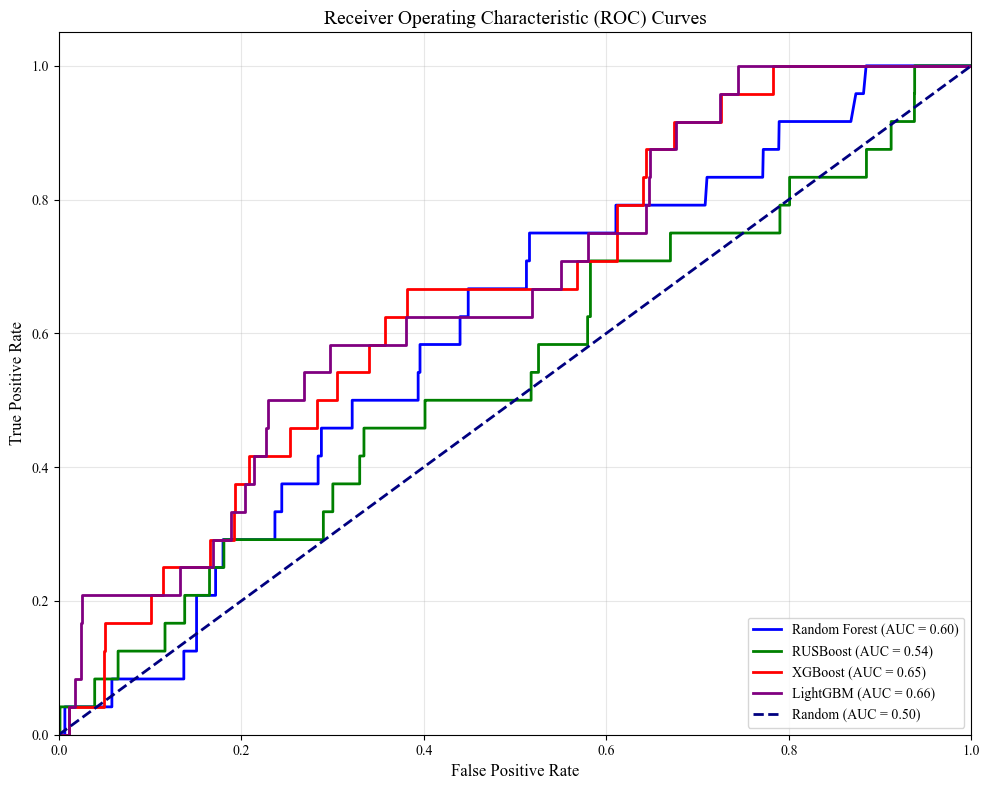

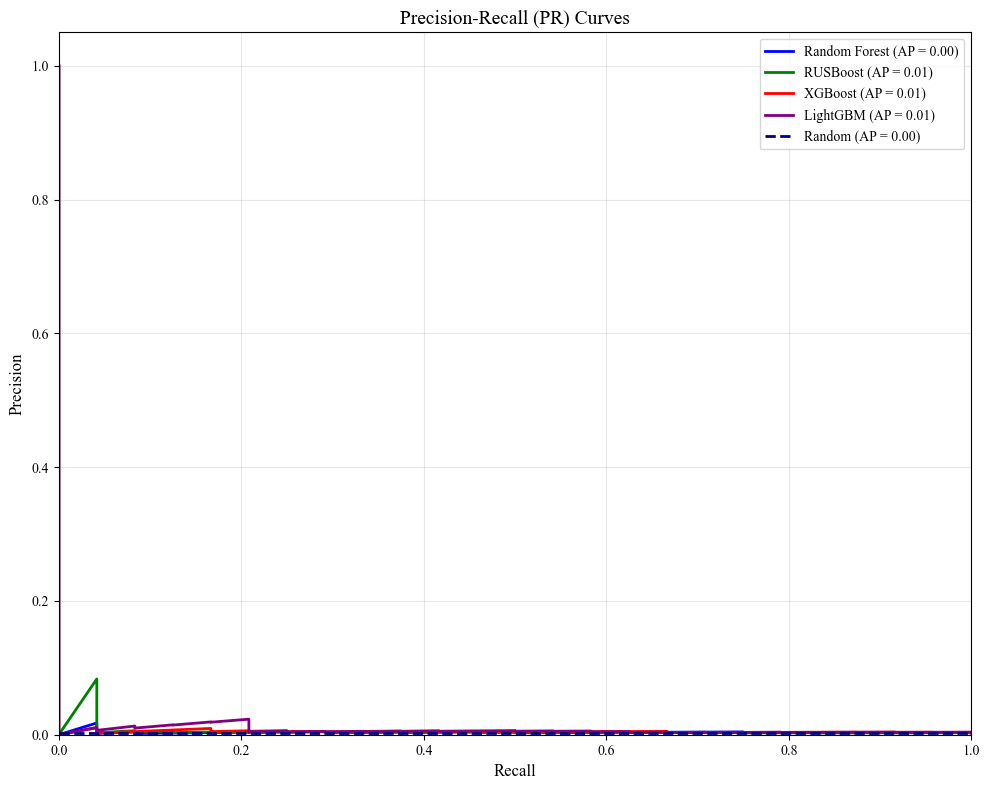

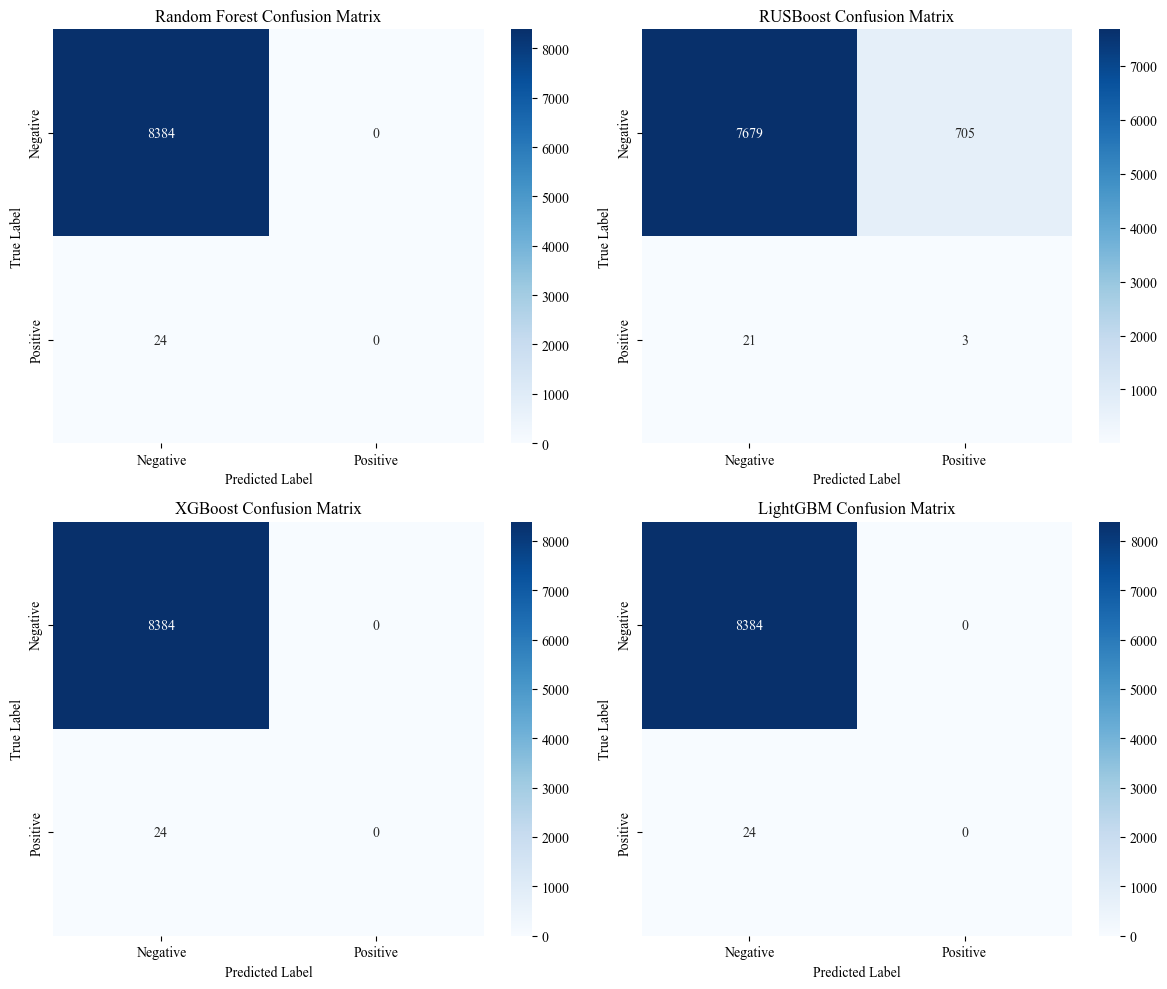

All charts have been saved as PNG files


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, result in enumerate(all_results):
    model_name = result['model_name']
    # Get true labels and predicted probabilities for test set
    y_test_true = y_test
    y_test_proba = result['model'].predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 8))

for i, result in enumerate(all_results):
    model_name = result['model_name']
    # Get true labels and predicted probabilities for test set
    y_test_true = y_test
    y_test_proba = result['model'].predict_proba(X_test)[:, 1]
    
    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(y_test_true, y_test_proba)
    avg_precision = average_precision_score(y_test_true, y_test_proba)
    
    # Plot PR curve
    plt.plot(recall, precision, color=colors[i], lw=2,
             label=f'{model_name} (AP = {avg_precision:.2f})')

# Calculate PR curve for random model
random_precision = len(y_test_true[y_test_true == 1]) / len(y_test_true)
plt.plot([0, 1], [random_precision, random_precision], color='navy', lw=2, linestyle='--',
         label=f'Random (AP = {random_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall (PR) Curves', fontsize=14)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, result in enumerate(all_results):
    model_name = result['model_name']
    # Get true labels and predicted classes for test set
    y_test_true = y_test
    y_test_pred = result['model'].predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_true, y_test_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[i].set_title(f'{model_name} Confusion Matrix', fontsize=12)
    axes[i].set_xlabel('Predicted Label', fontsize=10)
    axes[i].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("All charts have been saved as PNG files")

In [36]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def perform_cross_validation(model, X, y, model_name):
    """
    Run 5-fold Stratified CV and compute performance metrics.
    Works with classifiers that expose either predict_proba or decision_function for ROC AUC.
    """
    print(f"\n=== Starting 5-fold CV for {model_name} ===")

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0),
        # Use needs_threshold=True so it accepts either predict_proba or decision_function
        'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_results = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    # Aggregate means and stds
    cv_metrics = {
        'cv_accuracy': np.mean(cv_results['test_accuracy']),
        'cv_accuracy_std': np.std(cv_results['test_accuracy']),
        'cv_precision': np.mean(cv_results['test_precision']),
        'cv_precision_std': np.std(cv_results['test_precision']),
        'cv_recall': np.mean(cv_results['test_recall']),
        'cv_recall_std': np.std(cv_results['test_recall']),
        'cv_f1': np.mean(cv_results['test_f1']),
        'cv_f1_std': np.std(cv_results['test_f1']),
        'cv_auc': np.mean(cv_results['test_roc_auc']),
        'cv_auc_std': np.std(cv_results['test_roc_auc']),
    }

    print(f"{model_name} 5-fold CV results:")
    for metric, value in cv_metrics.items():
        print(f"  {metric}: {value:.4f}")

    return cv_metrics

# Merge train + val while preserving columns/index
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([
    pd.Series(y_train, index=X_train.index, name='target'),
    pd.Series(y_val, index=X_val.index, name='target')
], axis=0)

# Run CV for each fitted model (from all_results)
cv_results = {}
for result in all_results:
    model_name = result['model_name']
    model = result['model']
    cv_metrics = perform_cross_validation(model, X_train_val, y_train_val, model_name)
    cv_results[model_name] = cv_metrics

# Attach CV metrics to the results_df
for model_name, metrics in cv_results.items():
    idx = results_df[results_df['Model'] == model_name].index
    if len(idx) > 0:
        for metric, value in metrics.items():
            results_df.loc[idx, metric] = value

print("\n=== Full performance table with cross-validation ===")
print(results_df)

results_df.to_csv('model_performance_with_cv.csv', index=False, encoding='utf-8-sig')
print("Saved: model_performance_with_cv.csv")



=== Starting 5-fold CV for Random Forest ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Random Forest 5-fold CV results:
  cv_accuracy: 0.9899
  cv_accuracy_std: 0.0007
  cv_precision: 0.9917
  cv_precision_std: 0.0167
  cv_recall: 0.2706
  cv_recall_std: 0.0452
  cv_f1: 0.4235
  cv_f1_std: 0.0572
  cv_auc: 0.8795
  cv_auc_std: 0.0117

=== Starting 5-fold CV for RUSBoost ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


RUSBoost 5-fold CV results:
  cv_accuracy: 0.8892
  cv_accuracy_std: 0.0038
  cv_precision: 0.0505
  cv_precision_std: 0.0024
  cv_recall: 0.3968
  cv_recall_std: 0.0325
  cv_f1: 0.0895
  cv_f1_std: 0.0045
  cv_auc: 0.7752
  cv_auc_std: 0.0166

=== Starting 5-fold CV for XGBoost ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


XGBoost 5-fold CV results:
  cv_accuracy: 0.9900
  cv_accuracy_std: 0.0007
  cv_precision: 0.9791
  cv_precision_std: 0.0173
  cv_recall: 0.2760
  cv_recall_std: 0.0420
  cv_f1: 0.4292
  cv_f1_std: 0.0525
  cv_auc: 0.8727
  cv_auc_std: 0.0213

=== Starting 5-fold CV for LightGBM ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


LightGBM 5-fold CV results:
  cv_accuracy: 0.9904
  cv_accuracy_std: 0.0006
  cv_precision: 1.0000
  cv_precision_std: 0.0000
  cv_recall: 0.3009
  cv_recall_std: 0.0421
  cv_f1: 0.4610
  cv_f1_std: 0.0487
  cv_auc: 0.8787
  cv_auc_std: 0.0174

=== Full performance table with cross-validation ===
           Model  Search Time (s)    CV AUC  Val Accuracy  Val Sensitivity  \
0  Random Forest      1689.725824  0.883110      0.992862         0.000000   
1       RUSBoost       137.364939  0.777250      0.924967         0.232558   
2        XGBoost       153.653575  0.870396      0.992862         0.000000   
3       LightGBM      1339.415468  0.876804      0.992862         0.000000   

   Val Specificity  Val Precision    Val F1  Val Kappa   Val Auc  ...  \
0         1.000000        0.00000  0.000000   0.000000  0.754548  ...   
1         0.929945        0.02331  0.042373   0.029784  0.589230  ...   
2         1.000000        0.00000  0.000000   0.000000  0.794901  ...   
3         1.000000 

Calculating SHAP values...
SHAP values calculation completed!
SHAP values shape: (8408, 29)


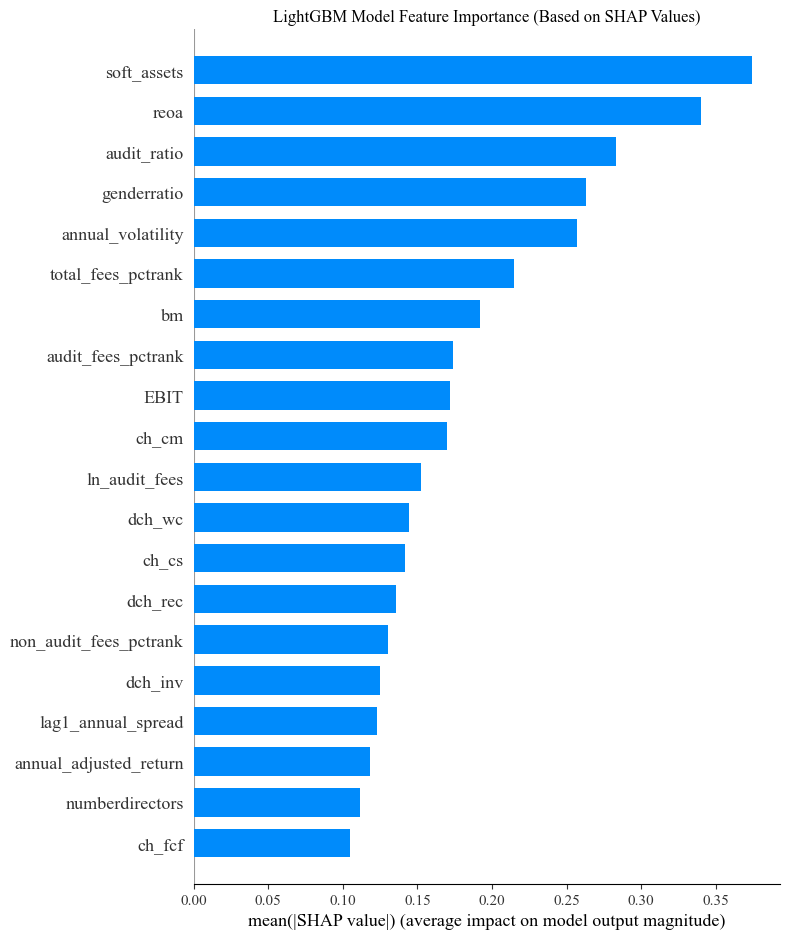

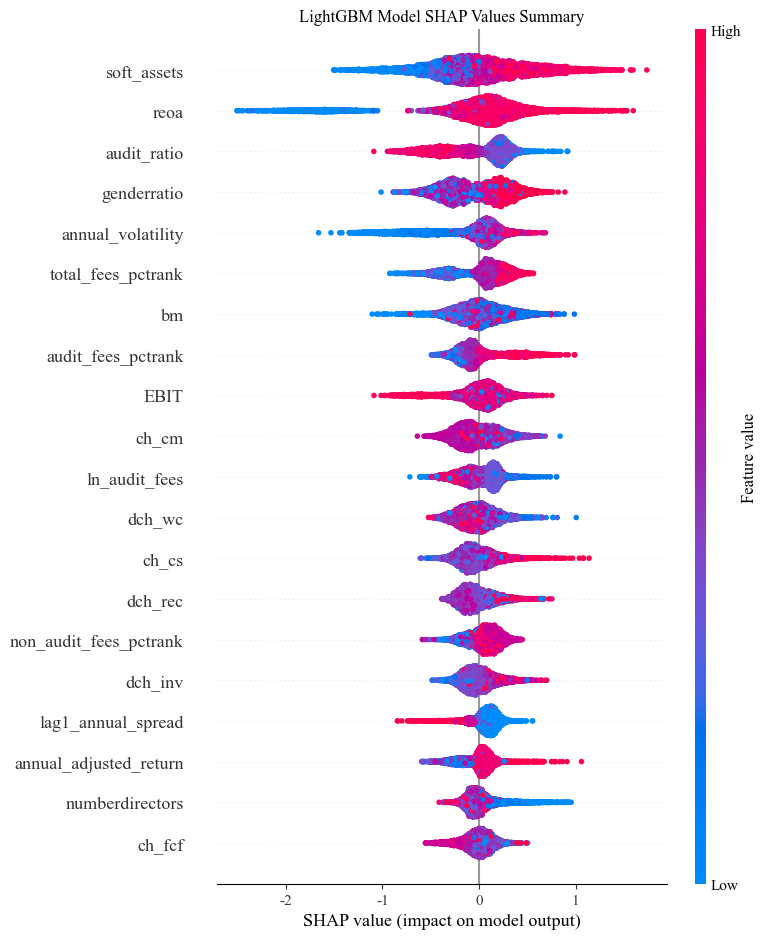

<Figure size 1200x400 with 0 Axes>

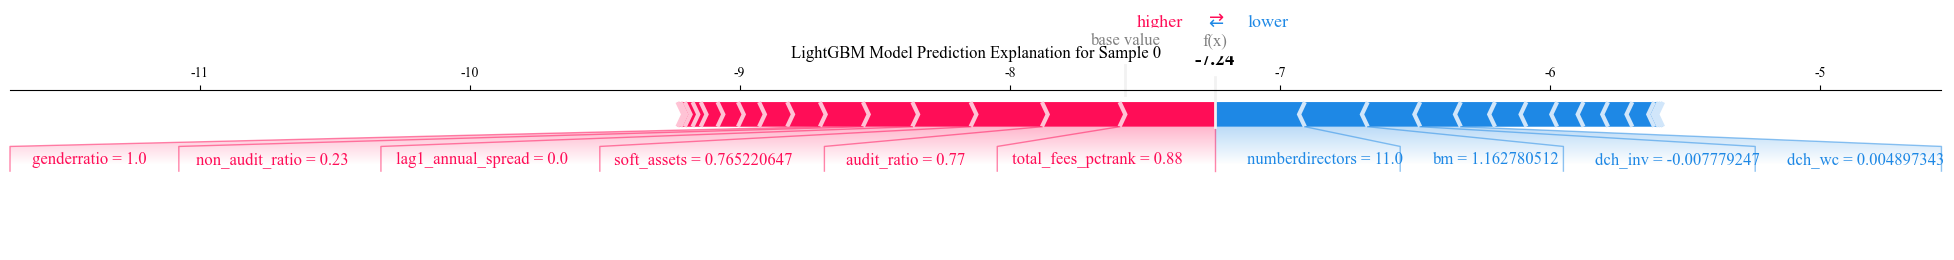

Most important feature: soft_assets


<Figure size 1000x800 with 0 Axes>

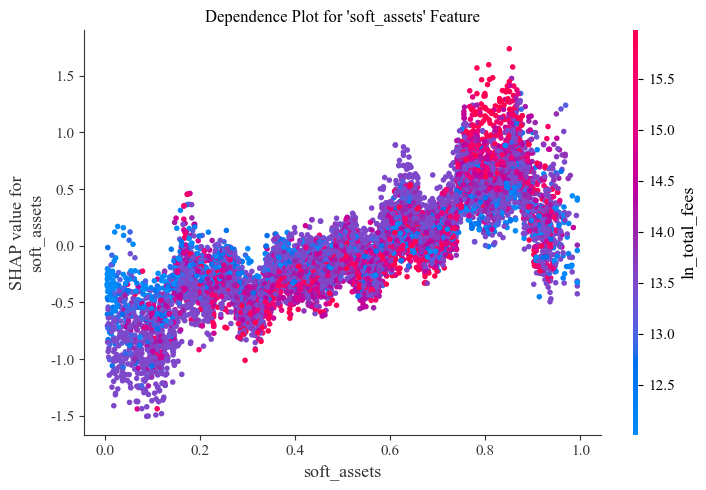

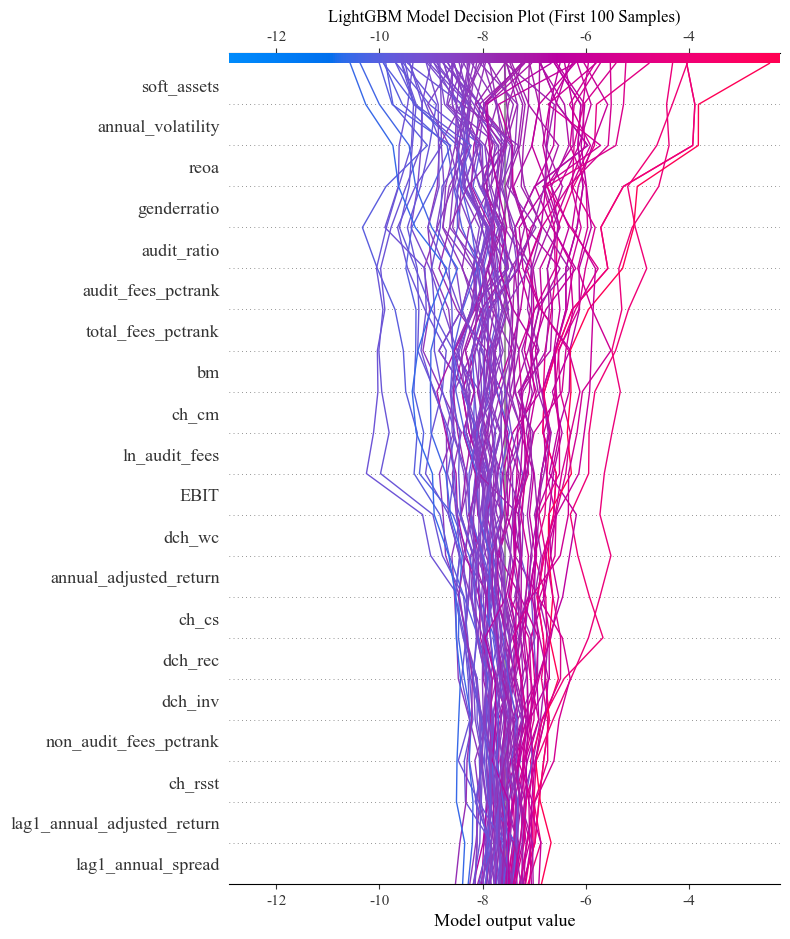

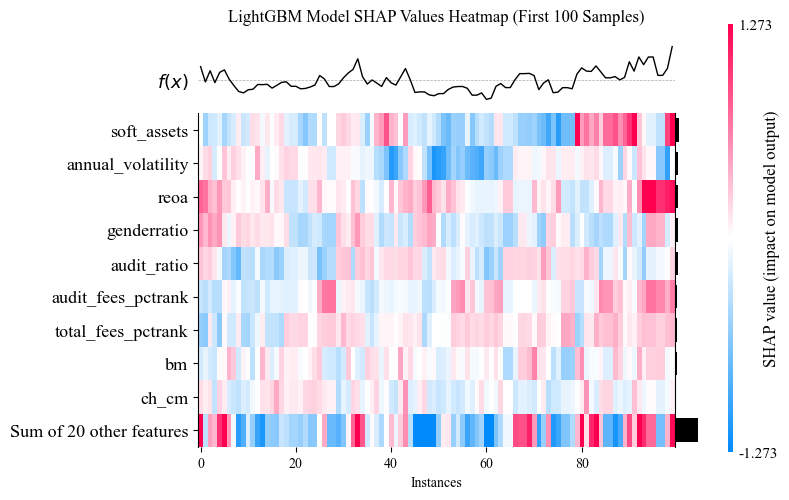

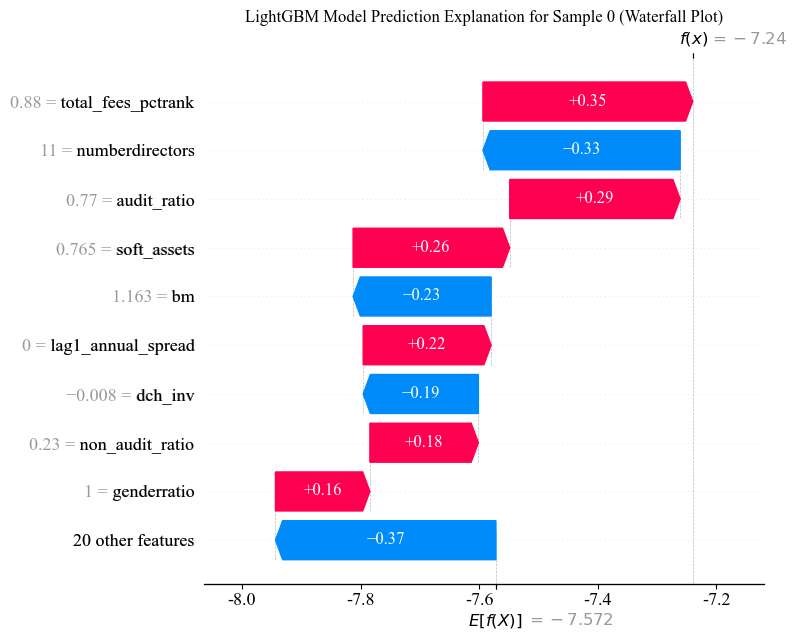


Feature importance ranking based on SHAP values:
               feature  mean_abs_shap
4          soft_assets       0.374217
11                reoa       0.339763
21         audit_ratio       0.282861
27         genderratio       0.263200
17   annual_volatility       0.256957
25  total_fees_pctrank       0.214628
9                   bm       0.191752
23  audit_fees_pctrank       0.173781
12                EBIT       0.171727
6                ch_cm       0.169574

SHAP values saved to lgbm_shap_values.csv

SHAP analysis completed! All plots have been saved as PNG files.


In [41]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Get the model from lgbm_results
lgbm_model = lgbm_results['model']

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for the test set
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test)

# For binary classification problems with LightGBM, SHAP values may be returned as a list
# We need to ensure we get the correct SHAP values array
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Typically index 1 represents SHAP values for the positive class

print("SHAP values calculation completed!")
print(f"SHAP values shape: {shap_values.shape}")

# 1. SHAP Feature Importance Plot (Bar Chart)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("LightGBM Model Feature Importance (Based on SHAP Values)")
plt.tight_layout()
plt.savefig('lgbm_shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. SHAP Summary Plot (Dot Plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("LightGBM Model SHAP Values Summary")
plt.tight_layout()
plt.savefig('lgbm_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Individual Prediction Explanation Plot (using the first sample in the test set as an example)
sample_idx = 0
plt.figure(figsize=(12, 4))
shap.force_plot(
    explainer.expected_value, 
    shap_values[sample_idx, :], 
    X_test.iloc[sample_idx, :],
    matplotlib=True,
    show=False
)
plt.title(f"LightGBM Model Prediction Explanation for Sample {sample_idx}")
plt.tight_layout()
plt.savefig('lgbm_shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Dependence Plot (analyzing how a specific feature affects predictions)
# Select the feature with the highest mean absolute SHAP value
feature_importance = np.abs(shap_values).mean(0)
most_important_feature_idx = np.argmax(feature_importance)
most_important_feature = X_test.columns[most_important_feature_idx]
print(f"Most important feature: {most_important_feature}")

plt.figure(figsize=(10, 8))
shap.dependence_plot(
    most_important_feature_idx, 
    shap_values, 
    X_test, 
    display_features=X_test,
    show=False
)
plt.title(f"Dependence Plot for '{most_important_feature}' Feature")
plt.tight_layout()
plt.savefig('lgbm_shap_dependence_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Decision Plot (showing SHAP values for multiple samples)
plt.figure(figsize=(12, 8))
shap.decision_plot(
    explainer.expected_value, 
    shap_values[:100],  # Show only first 100 samples to avoid overcrowding
    feature_names=X_test.columns.tolist(),
    show=False
)
plt.title("LightGBM Model Decision Plot (First 100 Samples)")
plt.tight_layout()
plt.savefig('lgbm_shap_decision_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Heatmap (showing SHAP values for multiple samples)
plt.figure(figsize=(12, 8))
shap.plots.heatmap(
    shap.Explanation(
        values=shap_values[:100],
        base_values=explainer.expected_value,
        data=X_test.values[:100],
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title("LightGBM Model SHAP Values Heatmap (First 100 Samples)")
plt.tight_layout()
plt.savefig('lgbm_shap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Waterfall Plot (detailed explanation for a single sample)
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title(f"LightGBM Model Prediction Explanation for Sample {sample_idx} (Waterfall Plot)")
plt.tight_layout()
plt.savefig('lgbm_shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Calculate and output mean SHAP values (average impact of features on model output)
mean_shap_values = np.mean(np.abs(shap_values), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_shap_values
}).sort_values('mean_abs_shap', ascending=False)

print("\nFeature importance ranking based on SHAP values:")
print(feature_importance_df.head(10))

# Save SHAP values results
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_df.to_csv('lgbm_shap_values.csv', index=False)
print("\nSHAP values saved to lgbm_shap_values.csv")

print("\nSHAP analysis completed! All plots have been saved as PNG files.")